# Accessing NOAA's National Centers for Environmental Information (NCEI) Climate Data Online

Climate Data Online provides developers access to historical climate and weather data. The API is broken into seven distinct endpoints branching off the main url `https://www.ncdc.noaa.gov/cdo-web/webservices/v2`. The following workbook will access the four below:

### Datasets
All of the CDO data are in datasets. The containing dataset must be known before attempting to access its data. Documentation on each of the datasets can be found on the following webpage: https://www.ncdc.noaa.gov/cdo-web/datasets

endpoint: `datasets`

### Locations
Locations can be a specific latitude/longitude point such as a station, or a label representing a bounding area such as a city.
endpoint: `locations`

### Stations
Stations are where the data comes from (for most datasets) and can be considered the smallest granual of location data. If the desired station is known, all of its data can quickly be viewed
endpoint: `stations`

### Data
The data endpoint is used for actually fetching the data.
endpoint: `data`
-----

**Notes**

* Documentation for NOAA [Link](https://www.ncdc.noaa.gov/cdo-web/webservices/v2)
* Corn-Producing States [Link](https://beef2live.com/story-states-produce-corn-0-107129)
* Daily Summaries Documentation [Link](https://www1.ncdc.noaa.gov/pub/data/cdo/documentation/GHCND_documentation.pdf)


**Date range: January 1, 2000 to December 31, 2019** 

In [123]:
import plotly.express as px
import requests
import pandas as pd
import time
import calendar
from datetime import datetime, timedelta
from dotenv import load_dotenv
import os


In [124]:
load_dotenv('keys.env')
token = os.getenv("token")

-------

The NOAA website has over 38,000 weather stations across the United States with varying levels of availability of data. As such, it is difficult to identify singular weather stations to extract. Moreover, due to the set up of the API, the data extraction needed to be done in three steps: 

1. Identification of the states of interest and their associated FIPS codes
2. Identification of individual weather stations with daily weather data
3. Extraction of weather data

## Step 1: Pulling a Listing of States and Associated FIPS Codes

Each State and County in the United States will have an associated Federal Information Processing System (FIPS) Code. FIPS codes will be either two to five characters in length and are used to uniquely identify geographic areas. 

There are over 3000 counties and county-equivalents (e.g. independent cities, parishes, boroughs) in the United States.

Resource: [https://transition.fcc.gov/](https://transition.fcc.gov/oet/info/maps/census/fips/fips.txt#:~:text=FIPS%20codes%20are%20numbers%20which,to%20which%20the%20county%20belongs)







In [126]:
# Specifies state-level data in the query
locationtype = 'locationcategoryid=ST'

# API defaults to returning 24 results. To retrieve all states, limit increased to 52
limit = '&limit=52'

# Send token to website and request listing of state and FIPS Codes
url = f'https://www.ncdc.noaa.gov/cdo-web/api/v2/locations?{locationtype}{limit}'
headers = { 'token': token}
response = requests.get(url,headers=headers)

# Response 200 means request returned succesfully
response

<Response [200]>

In [39]:
# Transform response into dataframe
results = response.json()
state_list = pd.DataFrame.from_dict(results['results'], orient='columns')
state_list.head()

,mindate,maxdate,name,datacoverage,id
0,1888-02-01,2020-11-22,Alabama,1,FIPS:01
1,1893-09-01,2020-11-22,Alaska,1,FIPS:02
2,1867-08-01,2020-11-22,Arizona,1,FIPS:04
3,1871-07-01,2020-11-22,Arkansas,1,FIPS:05
4,1850-10-01,2020-11-22,California,1,FIPS:06


In [40]:
# export listing of states and FIPS to csv
state_list.to_csv('../Resources/State_List.csv')

In [41]:
def get_stateFIPS(state):
    '''
    Returns FIPS code from csv file
    '''
    df = pd.read_csv('../Resources/State_List.csv')
    return df[df['name'] == state]['id'].iloc[0]

------
## Step 2: Identifying Individual Weather Stations with Daily Weather Data

With the returned FIPS codes, we can now pull ID codes for individual weather stations in each state.

Approximately 54% of corn crops in the United States are grown in five states: Illinois, Indiana, Nebraska, Ohio, and Iowa. To get an even sampling of weather data across these states, we will pull the first 10 weather stations retrieved in each state.

[Documentation on weather codes for GHCND Datasets](https://www1.ncdc.noaa.gov/pub/data/cdo/documentation/GHCND_documentation.pdf)

[Corn State Rankings](https://beef2live.com/story-states-produce-corn-0-107129)

In [42]:
corn_states = ['Illinois', 'Indiana', 'Nebraska','Ohio','Iowa']

In [127]:
for state in corn_states:
    # Query to retrieve information on max temperature (TMAX), min temperature (TMIN), and Precipitation (PRCP)
    datatype = '&datatypeid=TMAX&datatypeid=TMIN&datatypeid=PRCP'
    state_name = state
    FIPS = get_stateFIPS(state)
    limit = '&limit=10' # limit retrieval to first 10 weather stations
    location = f'&locationid={FIPS}'
    
    # Datefield in the query specifies the station needs to have 20 years of data in this range
    # Note: this datefield filter isn't great and you'll frequently see weather stations outside of this range
    datefield = f'&startdate=2000-01-01&enddate=2020-01-01'
    
    # Send token to website and request listing of weather stations
    url = f'https://www.ncdc.noaa.gov/cdo-web/api/v2/stations?datasetid=GHCND&{location}{datatype}{datefield}{limit}'
    headers = { 'token': token}
    response = requests.get(url,headers=headers)
    
    # transforming the data into a dataframe
    data = response.json()['results']
    df = pd.DataFrame.from_dict(data, orient='columns')
    df['State'] = state_name
    df['Location_ID'] = FIPS
    df = df.rename(columns={'id':'Station_ID','name':'City_Name'})
    
    # Appending weather stations for all 5 states to one csv
    with open(f'../Resources/station_dataset.csv', 'a') as f:
        df.to_csv(f, header=False,index=False)
        
    #API allows 5 requests per second
    time.sleep(1)
    
    print('Wrote:',state_name,'*'*100,end='\r')
print('complete','*'*100,end='\r')

In [43]:
# Retrieving weather station list for further use
state_df = pd.read_csv('../Resources/station_dataset.csv',
                       parse_dates=True,
                       infer_datetime_format=True,
                       names=['elevation','mindate','maxdate',
                              'latitude','name','datacoverage',
                              'id','elevationUnit','longitude',
                              'State','Location_ID'])
state_df.head()

,elevation,mindate,maxdate,latitude,name,datacoverage,id,elevationUnit,longitude,State,Location_ID
0,161.5,1893-12-01,2006-04-30,38.37770,"ALBION, IL US",0.7538,GHCND:USC00110055,METERS,-88.05690,Illinois,FIPS:17
1,222.5,1901-01-01,2020-11-20,41.19770,"ALEDO, IL US",0.9923,GHCND:USC00110072,METERS,-90.74470,Illinois,FIPS:17
2,123.4,1892-12-02,2020-11-20,38.86702,"ALTON MELVIN PRICE LOCK AND DAM, IL US",0.5784,GHCND:USC00110137,METERS,-90.14886,Illinois,FIPS:17
3,233.2,2005-02-01,2020-11-20,41.12040,"ALTONA, IL US",0.8515,GHCND:USC00110140,METERS,-90.16410,Illinois,FIPS:17
4,195.1,1895-05-05,2013-11-30,37.48130,"ANNA 2 NNE, IL US",0.9854,GHCND:USC00110187,METERS,-89.23440,Illinois,FIPS:17


## Location and Coverage of Selected Weather Stations
The graph below shows the location and relative data coverage of the selected weather stations in Illinois, Indiana, Nebraska, Ohio, and Iowa.

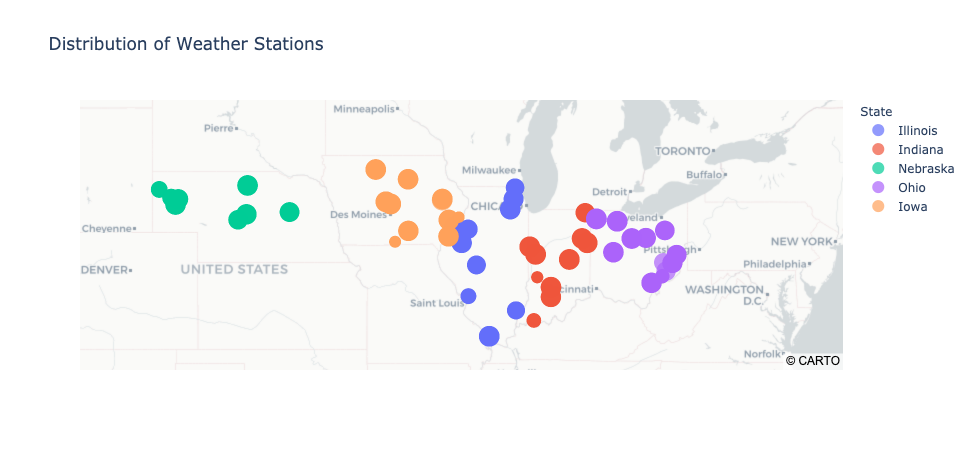

In [122]:
fig = px.scatter_mapbox(state_df, lat="latitude", lon="longitude", color="State", size="datacoverage",
                  color_continuous_scale=px.colors.cyclical.IceFire, size_max=15, zoom=4,
                  mapbox_style="carto-positron", title='Distribution of Weather Stations')
fig.show()

-------
## Step 3: Extracting Weather Data
Now that we have the individual weather stations, we can now extract data from those weather stations for 20 years.

In [48]:
years = [i for i in range(2000,2020)]
corn_states = ['Illinois', 'Indiana', 'Nebraska','Ohio','Iowa']

The following for loop with pull 20 years of data for each of the five states. The loop will individually save the data by state and year (ex. Iowa2001.csv)

In [60]:
for state in corn_states:
    
    # Query to retrieve information on max temperature (TMAX), min temperature (TMIN), and Precipitation (PRCP)
    datatype = '&datatypeid=TMAX&datatypeid=TMIN&datatypeid=PRCP'
    units = '&units=METRIC' #changes the data to Celsuis and Millimeters 
    offset = '&offset=1&limit=1000' # Max number of points you can retrieve is 1,000
    
    # Retrieving individual weather station codes
    station_code = list(state_df[state_df['State'] == state]['id'].values)
    
    station_id = ''
    
    # joining all the station_ids for a state together in a string for the query
    for station in station_code:
        station_id += f'&stationid={station}'

    for year in years:

        counter = 1 # keeping track of the months
        
        # modifying the month query to obey format YYYY-MM-DD
        for month in range(1,13):
            if month < 10:
                date = f'{year}-0{month}-'
            else:
                date = f'{year}-{month}-'

            last_day = calendar.monthrange(year, month)[1]
            
            # Pulling data on a monthly basis to not exceed the 1,000 limit
            datefield = f'&startdate={date}01&enddate={date}{last_day}'
            
            # Send token to website and request
            url = f'https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND{datatype}{units}{station_id}{datefield}{offset}'
            headers = { 'token': token}
            response = requests.get(url,headers=headers)


            response.json()
            
            # Printing a results report to know where the loop is in the process.
            print('Month Results: ',response.json()['metadata'],'Year: ',year,'Month:',counter,'State:',state,end='\r')

            data = response.json()['results']
            df = pd.DataFrame.from_dict(data, orient='columns')
            
            # Appending all the monthly results to a csv file by state and year.
            with open(f'../Resources/weather_data/State_Annual_Data/{state}{year}.csv', 'a') as f:
                df.to_csv(f, header=False,index=False)
                
            counter += 1
            time.sleep(1)


In [23]:
# If the program fails, check the response.
response

<Response [200]>

-------
## Data Cleaning
The API has outputted data into csv files, which needs to be cleaned. Stations often had multiple datapoints per day, and some states did not have 10 weather stations. To approach this problem, we've decided to average the daily data for each station to produce one datapoint per state.

As well, each state's 20 years of data exists in 20 separate csv files, which must be combined.

In [25]:
def clean_data(filename):
    '''
    Function removes duplicates, cleans data, and averages results by state and date.
    '''
    df = pd.read_csv(filename,names=['date','weather_type','id','drop','values'],parse_dates=True,infer_datetime_format=True)
    
    df = df.drop_duplicates()
    
    df = pd.DataFrame(df.groupby(['date','weather_type']).mean()['values'])
    df = df.reset_index()

    df = df.pivot_table(index=['date'], 
                     columns='weather_type', 
                     values='values')
    
    df = df.reset_index()
    df["date"] = pd.to_datetime(df["date"])
    df['date'] = df["date"].dt.strftime("%Y-%m-%d")
    
    return df

In [ ]:
years = [i for i in range(2000,2020)]
corn_states = ['Illinois', 'Indiana', 'Nebraska','Ohio','Iowa']

In [381]:
# Combines all the years for one state into one csv file

# Initialize empty dataframe
all_years = pd.DataFrame(columns=['weather_type','date','PRCP','TMAX','TMIN'])

for state in corn_states:
    for year in years:
        
        # clean data for individual state/year file.
        df = clean_data(f'../Resources/weather_data/State_Annual_Data/{state}{year}.csv')
        
        # append clean data to dataframe
        all_years = pd.concat([all_years,df], axis=0,ignore_index=True)
    
    # write the combined 20 years of data for the state to one csv
    all_years.to_csv(f'../Resources/weather_data/State_20yr_Data/{state}_20yrs.csv')
    
    # creates a clean df before cleaning the next state
    all_years = pd.DataFrame(columns=['weather_type','date','PRCP','TMAX','TMIN'])


In [382]:
# Cleans columns in combined files
for state in corn_states:
    df = pd.read_csv(f'../Resources/weather_data/State_20yr_Data/{state}_20yrs.csv')
    df = df.drop(columns=['Unnamed: 0', 'weather_type'])
    df.to_csv(f'../Resources/weather_data/State_20yr_Data/{state}_20yrs.csv')

----------
## Transforming Data for Analysis
### 1. Combining State Weather Data into One File
The data is now clean in 20 year datasets in separate csv files. We will next combine the data into one dataframe/file.

In [1]:
corn_states = ['Illinois', 'Indiana', 'Iowa', 'Nebraska','Ohio']

In [32]:
# Initialize empty dataframe
all_years = pd.DataFrame(columns=['date','PRCP','TMAX','TMIN'])
all_years = all_years.set_index('date')

for state in corn_states:
    df = pd.read_csv(f'../Resources/weather_data/State_20yr_Data/{state}_20yrs.csv',
                     index_col='date',
                     infer_datetime_format=True,
                     parse_dates=True)
    
    df = df.drop(columns=['Unnamed: 0'])
    
    # Naming the columns according to weather type and state
    df = df.rename(columns={'PRCP':f'PRCP_{state}','TMAX':f'TMAX_{state}','TMIN':f'TMIN_{state}'})
    
    all_years = pd.concat([all_years,df], axis=1, join='outer')


all_years = all_years.drop(columns=['PRCP','TMAX','TMIN'])

In [33]:
all_years.head()

,PRCP_Illinois,TMAX_Illinois,TMIN_Illinois,PRCP_Indiana,TMAX_Indiana,TMIN_Indiana,PRCP_Nebraska,TMAX_Nebraska,TMIN_Nebraska,PRCP_Ohio,TMAX_Ohio,TMIN_Ohio,PRCP_Iowa,TMAX_Iowa,TMIN_Iowa
date,,,,,,,,,,,,,,,
2000-01-01 00:00:00,0.000000,7.78,-2.340000e+00,0.00,10.6375,-3.4125,0.0000,9.757143,-5.785714,0.000000,9.1000,-5.700000,0.000000,6.94,-4.16
2000-01-02 00:00:00,0.166667,12.44,8.800000e-01,0.31,15.2125,1.3250,0.0375,6.312500,-7.425000,0.000000,13.6125,-0.287500,0.254545,5.50,-0.66
2000-01-03 00:00:00,0.000000,13.44,8.881784e-17,23.47,15.8375,5.7625,0.2875,0.975000,-10.062500,6.387500,17.0875,6.812500,0.254545,4.43,-1.72
2000-01-04 00:00:00,5.533333,3.00,-5.000000e+00,19.61,13.0000,-0.5625,0.1250,-2.000000,-19.100000,33.162500,14.2875,4.662500,3.140000,-1.16,-10.92
2000-01-05 00:00:00,0.000000,-1.10,-1.256000e+01,0.34,0.2875,-5.5000,0.0750,3.837500,-11.187500,1.157143,6.1250,-3.571429,0.000000,-4.38,-14.89


In [34]:
# Outputting the combined data to a csv file to be used in analysis.
all_years.to_csv('../Resources/corn_belt_weather.csv')

### 2. Outputting dataset with extreme weather flags
Corn can't survive below 0 degrees or above 34 degrees. We will give the data a flag if it goes above or below this threshold

In [36]:
all_years_w_ext = all_years.copy()

In [35]:
corn_states = ['Illinois', 'Indiana', 'Iowa', 'Nebraska','Ohio']

In [37]:
for state in corn_states:
    extreme_heat = []
    extreme_cold = []
    
    for i in range(len(all_years_w_ext)):
        # If min or max temp goes above 43, flag
        if all_years_w_ext.loc[all_years_w_ext.index[i],f'TMAX_{state}'] > 43 or all_years_w_ext.loc[all_years_w_ext.index[i],f'TMIN_{state}'] > 43:
            extreme_heat.append(1)
        else:
            extreme_heat.append(0) 

        # If min or max temp goes below 0,flag
        if all_years_w_ext.loc[all_years_w_ext.index[i],f'TMAX_{state}'] < 0 or all_years_w_ext.loc[all_years_w_ext.index[i],f'TMIN_{state}'] < 0:
            extreme_cold.append(1)
        else:
            extreme_cold.append(0)
            
    # append new columns to dataset
    all_years_w_ext[f'extreme_heat_{state}'] = extreme_heat
    all_years_w_ext[f'extreme_cold_{state}'] = extreme_cold  

In [38]:
all_years_w_ext.head()

,PRCP_Illinois,TMAX_Illinois,TMIN_Illinois,PRCP_Indiana,TMAX_Indiana,TMIN_Indiana,PRCP_Nebraska,TMAX_Nebraska,TMIN_Nebraska,PRCP_Ohio,...,extreme_heat_Illinois,extreme_cold_Illinois,extreme_heat_Indiana,extreme_cold_Indiana,extreme_heat_Iowa,extreme_cold_Iowa,extreme_heat_Nebraska,extreme_cold_Nebraska,extreme_heat_Ohio,extreme_cold_Ohio
date,,,,,,,,,,,,,,,,,,,,,
2000-01-01 00:00:00,0.000000,7.78,-2.340000e+00,0.00,10.6375,-3.4125,0.0000,9.757143,-5.785714,0.000000,...,0,1,0,1,0,1,0,1,0,1
2000-01-02 00:00:00,0.166667,12.44,8.800000e-01,0.31,15.2125,1.3250,0.0375,6.312500,-7.425000,0.000000,...,0,0,0,0,0,1,0,1,0,1
2000-01-03 00:00:00,0.000000,13.44,8.881784e-17,23.47,15.8375,5.7625,0.2875,0.975000,-10.062500,6.387500,...,0,0,0,0,0,1,0,1,0,0
2000-01-04 00:00:00,5.533333,3.00,-5.000000e+00,19.61,13.0000,-0.5625,0.1250,-2.000000,-19.100000,33.162500,...,0,1,0,1,0,1,0,1,0,0
2000-01-05 00:00:00,0.000000,-1.10,-1.256000e+01,0.34,0.2875,-5.5000,0.0750,3.837500,-11.187500,1.157143,...,0,1,0,1,0,1,0,1,0,1


In [ ]:
all_years_w_ext.to_csv('../Resources/corn_belt_w_extremes.csv')

### 3. Adding Year, Month, and Season Columns

In [66]:
def add_season(df):
    Season = []
    
    df.index = pd.to_datetime(df.index)
    
    for i in range(len(df)):
        if df.index.month[i] in [12,1,2]:
            Season.append('Winter')
        elif df.index.month[i] in [3,4,5]: # March to May
            Season.append('Spring')
        elif df.index.month[i] in [6,7,8]: 
            Season.append('Summer')
        else:
            Season.append('Fall')
            
    
    df['Season'] = Season
    df['Year'] = df.index.year
    df['Month'] = df.index.month
    
    return df

In [67]:
season_df = add_season(corn_df)

In [68]:
season_df.columns

Index(['PRCP_Illinois', 'TMAX_Illinois', 'TMIN_Illinois', 'PRCP_Indiana',
       'TMAX_Indiana', 'TMIN_Indiana', 'PRCP_Nebraska', 'TMAX_Nebraska',
       'TMIN_Nebraska', 'PRCP_Ohio', 'TMAX_Ohio', 'TMIN_Ohio', 'PRCP_Iowa',
       'TMAX_Iowa', 'TMIN_Iowa', 'Season', 'Year', 'Month'],
      dtype='object')

------
## Analysis of Weather Data
Run the final line of code below to launch the dashboard and explore the data. The dashboard compares temperature extremes and precipitation.

In [137]:
!python Weather_Dashboard_Final.py

/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/xarray/core/merge.py:10: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)
Launching server at http://localhost:61628
^C
